This is the data cleaning and feature engineering aspect of the Supervised Learning capstone.

In [329]:
#import the necessities
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
import math
import warnings
from scipy.stats import bartlett, boxcox, jarque_bera, levene, normaltest, zscore
from scipy.stats.mstats import winsorize
from sklearn import ensemble
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.tree import DecisionTreeRegressor
from sqlalchemy import create_engine
from statsmodels.tools.eval_measures import mse, rmse
from xgboost import XGBClassifier
%matplotlib inline
warnings.filterwarnings('ignore')

In [92]:
#get the data which will become our model
df = pd.read_csv('D:/Downloads/cardsutf8.txt', sep='\t', encoding='latin1', low_memory=False)

In [211]:
#check the data (specifically the columns)
df.columns

Index(['index', 'id', 'artist', 'asciiName', 'availability', 'borderColor',
       'cardKingdomFoilId', 'cardKingdomId', 'colorIdentity', 'colorIndicator',
       'colors', 'convertedManaCost', 'duelDeck', 'edhrecRank',
       'faceConvertedManaCost', 'faceName', 'flavorName', 'flavorText',
       'frameEffects', 'frameVersion', 'hand', 'hasAlternativeDeckLimit',
       'hasContentWarning', 'hasFoil', 'hasNonFoil', 'isAlternative',
       'isFullArt', 'isOnlineOnly', 'isOversized', 'isPromo', 'isReprint',
       'isReserved', 'isStarter', 'isStorySpotlight', 'isTextless',
       'isTimeshifted', 'keywords', 'layout', 'leadershipSkills', 'life',
       'loyalty', 'manaCost', 'mcmId', 'mcmMetaId', 'mtgArenaId',
       'mtgjsonV4Id', 'mtgoFoilId', 'mtgoId', 'multiverseId', 'name', 'number',
       'originalReleaseDate', 'originalText', 'originalType', 'otherFaceIds',
       'power', 'printings', 'promoTypes', 'purchaseUrls', 'rarity',
       'scryfallId', 'scryfallIllustrationId', 'scryfa

The goal of this capstone is to try to predict the power (and any further attributes if possible). To that end, there are several features in this set that are not values intrinsic to the card itself, suck as cardKingdomId, edhrecRank, mcmId, etc. We will keep anything that would appear on the printed card.

In [212]:
#get the columns of interest
cards = df[['artist', 'borderColor', 'colorIdentity', 'colorIndicator', 'colors',
            'convertedManaCost', 'faceConvertedManaCost', 'faceName',  'flavorText',
            'frameEffects', 'frameVersion', 'hand', 'hasAlternativeDeckLimit',
            'isFullArt', 'isPromo', 'isTextless', 'isTimeshifted', 'keywords',
            'layout', 'leadershipSkills', 'life', 'loyalty', 'manaCost', 'name',
            'power', 'rarity', 'setCode', 'side', 'subtypes', 'supertypes', 'text', 
            'toughness', 'type', 'types', 'variations', 'watermark']]

In [213]:
#check the data to see what might be useful
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56832 entries, 0 to 56831
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   artist                   56829 non-null  object 
 1   borderColor              56832 non-null  object 
 2   colorIdentity            50608 non-null  object 
 3   colorIndicator           167 non-null    object 
 4   colors                   44292 non-null  object 
 5   convertedManaCost        56832 non-null  float64
 6   faceConvertedManaCost    955 non-null    float64
 7   faceName                 1367 non-null   object 
 8   flavorText               30812 non-null  object 
 9   frameEffects             2958 non-null   object 
 10  frameVersion             56832 non-null  object 
 11  hand                     118 non-null    float64
 12  hasAlternativeDeckLimit  56832 non-null  int64  
 13  isFullArt                56832 non-null  int64  
 14  isPromo               

There are plenty of cards that have null values. For now, let's clear some of the rows that aren't going to be useful for our project.

In [214]:
#gold and silver cards are not legal for play and borderless is just a frame type
#so strip away all but black and white border
cards = cards[(cards['borderColor'] != 'borderless') & (cards['borderColor'] != 'silver')
             & (cards['borderColor'] != 'gold')]

In [215]:
#we're only going to use this model for creatures, as those have less variance than other
#types of cards
cards = cards[cards['type'].str.contains('Creature')]

In [216]:
#some of the powers aren't integers due to effects, so since those aren't easily
#predictable, we'll drop the problem cards
cards = cards[(cards['power'] != '*') & (cards['power'] != '1+*') & 
              (cards['power'] != '2+*') & (cards['power'] != '?')]
#same with toughness
cards = cards[(cards['toughness'] != '*') & (cards['toughness'] != '1+*')]
#and a weird one where the manaCost = {S}
cards = cards[cards['manaCost'] != '{S}']

In [217]:
#these columns are useful but would be more useful as numbers
cards['power'] = cards['power'].astype(int)
cards['toughness'] = cards['toughness'].astype(int)
cards['convertedManaCost'] = cards['convertedManaCost'].astype(int)

In [218]:
#now that we've pared it down, let's check the null values again.
cards.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25032 entries, 0 to 56831
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   artist                   25032 non-null  object 
 1   borderColor              25032 non-null  object 
 2   colorIdentity            23767 non-null  object 
 3   colorIndicator           90 non-null     object 
 4   colors                   23514 non-null  object 
 5   convertedManaCost        25032 non-null  int32  
 6   faceConvertedManaCost    321 non-null    float64
 7   faceName                 467 non-null    object 
 8   flavorText               15916 non-null  object 
 9   frameEffects             2005 non-null   object 
 10  frameVersion             25032 non-null  object 
 11  hand                     0 non-null      float64
 12  hasAlternativeDeckLimit  25032 non-null  int64  
 13  isFullArt                25032 non-null  int64  
 14  isPromo               

colorIndicator, faceConvertedManaCost, faceName, hand, leadershipSkills, life, loyalty, side, supertypes, variations, and watermarks all have significant null portions, so we'll drop those. We'll look at the other columns to see what their values are to see if the nulls can be filled or if they need to be dropped.<br>
EDIT: supertype, through feature engineering, was found to have use, so it wasn't removed here in a later iteration.

In [219]:
cards = cards.drop(['colorIndicator', 'faceConvertedManaCost', 'faceName', 'hand',
                    'leadershipSkills', 'life', 'loyalty', 'side', 'variations', 'watermark'], axis=1)

In [220]:
#we'll use nunique(dropna) to see how many different values we're working with
columns = cards.select_dtypes(include=['object'])
for n in columns:
    column = columns[n]
    print(n)
    print(column.nunique(dropna=False))

artist
753
borderColor
2
colorIdentity
32
colors
33
flavorText
9044
frameEffects
34
frameVersion
5
keywords
993
layout
7
manaCost
543
name
11143
rarity
4
setCode
433
subtypes
1247
supertypes
4
text
10213
type
1646
types
5


artist, flavorText, keywords, manaCost, name, subtypes, text, and type all have more than 500 values as objects. artist, flavorText, and name are unlikely to have any effect on our target; however, name is a useful identifier so we won't drop it until later. keywords, manaCost, subtypes, and text are possibly relevant, so we'll look at the values to see if we can get engineer useful features from them.

In [221]:
cards = cards.drop(['artist', 'flavorText'], 1)

In [222]:
#we'll use value_counts and unique to see what the values are
cards['colorIdentity'].value_counts(dropna=False)

G            4548
R            3993
B            3984
W            3905
U            3516
NaN          1265
G,W           369
G,R           352
B,R           342
B,U           332
U,W           323
G,U           286
B,G           278
R,W           261
R,U           241
B,W           210
B,G,R,U,W      99
G,R,W          93
G,U,W          86
B,U,W          79
B,G,R          78
B,R,U          77
B,R,W          66
B,G,U          65
B,G,W          53
G,R,U          52
R,U,W          47
G,R,U,W         8
B,R,U,W         7
B,G,U,W         7
B,G,R,W         5
B,G,R,U         5
Name: colorIdentity, dtype: int64

In [223]:
cards['colors'].value_counts(dropna=False)

G            4649
R            4052
B            4028
W            3966
U            3520
NaN          1518
G,W           327
G,R           312
U,W           286
B,U           285
B,R           285
G,U           267
B,G           240
R,W           237
R,U           220
B,W           185
G,R,W          70
B,U,W          68
G,U,W          66
B,G,R          66
B,R,U          64
B,R,W          54
B,G,R,U,W      52
B,G,U          50
B,G,W          46
R,U,W          42
G,R,U          42
G,R,U,W         8
B,G,U,W         7
B,R,U,W         7
B,G,R,W         5
B,G,R,U         5
W,G             3
Name: colors, dtype: int64

In [224]:
cards['frameEffects'].value_counts(dropna=False)

NaN                                 23027
legendary                             911
nyxtouched                            180
sunmoondfc                            157
extendedart                           154
devoid                                 97
showcase                               86
legendary,etched                       66
legendary,extendedart                  51
nyxtouched,legendary                   43
showcase,legendary                     36
etched,legendary                       33
mooneldrazidfc                         31
colorshifted                           27
originpwdfc                            20
inverted                               16
snow                                   14
tombstone                              14
draft                                  13
companion,legendary                    10
companion,legendary,extendedart        10
extendedart,legendary                   9
nyxtouched,showcase,legendary           6
extendedart,nyxtouched            

In [225]:
cards['frameVersion'].value_counts(dropna=False)

2015      11622
2003       7550
1997       3860
1993       1948
future       52
Name: frameVersion, dtype: int64

In [226]:
cards['keywords'].value_counts(dropna=False)

NaN                                 11900
Flying                               2975
Trample                               563
Defender                              389
Haste                                 374
                                    ...  
Deathtouch,First strike,Level Up        1
Indestructible,Level Up,Lifelink        1
Flash,Split second                      1
Fear,Modular                            1
Parley,Trample                          1
Name: keywords, Length: 993, dtype: int64

In [227]:
cards['layout'].value_counts(dropna=False)

normal       24518
transform      213
adventure      108
modal_dfc       66
flip            64
leveler         47
meld            16
Name: layout, dtype: int64

In [228]:
cards['manaCost'].value_counts(dropna=False)

{1}{G}                       794
{2}{R}                       768
{1}{W}                       754
{2}{G}                       746
{2}{B}                       704
                            ... 
{U/B}                          1
{R/G}{R/G}{R/G}{R/G}           1
{4}{W}{W}{B}{B}                1
{W/U}{W/U}{W/U}{W/U}{W/U}      1
{4}{W}{U}{U}{B}                1
Name: manaCost, Length: 543, dtype: int64

In [229]:
cards['rarity'].value_counts(dropna=False)

common      8682
rare        7821
uncommon    6856
mythic      1673
Name: rarity, dtype: int64

In [230]:
cards['setCode'].value_counts(dropna=False)

MB1      858
PRM      581
CMR      384
PSAL     291
JMP      283
        ... 
P10E       1
PWP12      1
PCNS       1
PCON       1
PTMP       1
Name: setCode, Length: 433, dtype: int64

In [231]:
cards['subtypes'].value_counts(dropna=False)

Human,Wizard          898
Elemental             763
Human,Soldier         738
Spirit                619
Beast                 556
                     ... 
Merfolk,Zombie          1
Ogre,Spirit             1
Nautilus,Beast          1
Human,Druid,Wizard      1
Elephant,Wurm           1
Name: subtypes, Length: 1247, dtype: int64

In [232]:
cards['type'].value_counts(dropna=False)

Creature â Human Wizard            735
Creature â Elemental               716
Creature â Human Soldier           627
Creature â Spirit                  515
Creature â Beast                   512
                                    ... 
Creature â Vampire Archer            1
Creature â Human Druid Shaman        1
Creature â Worm Horror               1
Snow Creature â Centaur Warrior      1
Creature â Spike Drone               1
Name: type, Length: 1646, dtype: int64

In [233]:
cards['types'].value_counts(dropna=False)

Creature                23284
Artifact,Creature        1499
Enchantment,Creature      243
Land,Creature               4
Instant,Creature            2
Name: types, dtype: int64

colorIndentity, colors, frameEffects, manaCost, subtypes, and type, even though they have multiple different values, have multiple values in common. For example, in colors, W, G, and W,G exist, so we can create a binary value for 'contains Green', 'contains White', etc. The null values correspond to colorless creatures, so to avoid those being unintentionally included with the .str.contains(). keywords might but it is not immediately obvious based on the truncated response. A quick call of .unique() will show if it is also the same.

In [234]:
cards['keywords'].unique()

array(['First strike', 'Flying', nan, 'First strike,Flash', 'Mill',
       'Swampwalk', 'Islandwalk,Landwalk', 'Flying,Vigilance',
       'First strike,Protection', 'Haste', 'Fear', 'Flying,Trample',
       'Trample', 'Mountainwalk', 'Reach',
       'First strike,Forestwalk,Vigilance', 'Shroud',
       'First strike,Flying', 'Forestwalk', 'Defender,Flying', 'Hexproof',
       'Haste,Trample', 'Flash,Reach', 'Menace', 'Defender',
       'Double strike,Flying', 'Vigilance', 'Banding', 'Banding,Flying',
       'Flying,Lifelink', 'Flying,Indestructible,Vigilance',
       'Double strike', 'Fabricate', 'Metalcraft', 'Lifelink',
       'Investigate', 'Flying,Scry', 'Islandwalk,Landwalk,Shroud,Trample',
       'Flash', 'Deathtouch,Flying', 'Intimidate,Mill', 'Morbid',
       'Exploit,Flying', 'Flying,Infect', 'Swampcycling', 'Bloodrush',
       'Landfall', 'Devour', 'Forestcycling', 'Exalted', 'Ferocious',
       'Deathtouch,Flying,Lifelink,Proliferate,Vigilance', 'Flying,Haste',
       'Blood

keywords is the same, with the null values indicating that there are no keywords on the card. we'll fill the nulls and check our data again.

In [235]:
#the nulls in colors relate to colorless creatures, so we'll
#fill that with C to represent those. 
cards['colors'] = cards['colors'].fillna('C')
#the nulls in keywords means nothing there, so we'll fill
#that null with "No Keywords"
cards['keywords'] = cards['keywords'].fillna('No keywords')

In [236]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25032 entries, 0 to 56831
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   borderColor              25032 non-null  object
 1   colorIdentity            23767 non-null  object
 2   colors                   25032 non-null  object
 3   convertedManaCost        25032 non-null  int32 
 4   frameEffects             2005 non-null   object
 5   frameVersion             25032 non-null  object
 6   hasAlternativeDeckLimit  25032 non-null  int64 
 7   isFullArt                25032 non-null  int64 
 8   isPromo                  25032 non-null  int64 
 9   isTextless               25032 non-null  int64 
 10  isTimeshifted            25032 non-null  int64 
 11  keywords                 25032 non-null  object
 12  layout                   25032 non-null  object
 13  manaCost                 24897 non-null  object
 14  name                     25032 non-nul

frameEffects might allow a single card to have multiple entries when it shouldn't. Lovestruck Beast is one such card, so it would be easy to test that.

In [237]:
lvb = cards[cards['name'] == "Lovestruck Beast // Heart's Desire"]

In [238]:
lvb.head()

,borderColor,colorIdentity,colors,convertedManaCost,frameEffects,frameVersion,hasAlternativeDeckLimit,isFullArt,isPromo,isTextless,...,name,power,rarity,setCode,subtypes,supertypes,text,toughness,type,types
17947,black,G,G,3,NaN,2015,0,0,0,0,...,Lovestruck Beast // Heart's Desire,5,rare,ELD,"Beast,Noble",NaN,Lovestruck Beast can't attack unless you contr...,5,Creature â Beast Noble,Creature
18111,black,G,G,3,showcase,2015,0,0,0,0,...,Lovestruck Beast // Heart's Desire,5,rare,ELD,"Beast,Noble",NaN,Lovestruck Beast can't attack unless you contr...,5,Creature â Beast Noble,Creature
38702,black,G,G,3,NaN,2015,0,0,1,0,...,Lovestruck Beast // Heart's Desire,5,rare,PELD,"Beast,Noble",NaN,Lovestruck Beast can't attack unless you contr...,5,Creature â Beast Noble,Creature
38704,black,G,G,3,NaN,2015,0,0,1,0,...,Lovestruck Beast // Heart's Desire,5,rare,PELD,"Beast,Noble",NaN,Lovestruck Beast can't attack unless you contr...,5,Creature â Beast Noble,Creature
42978,black,G,G,3,NaN,2015,0,0,1,0,...,Lovestruck Beast // Heart's Desire,5,rare,PRM,"Beast,Noble",NaN,Lovestruck Beast can't attack unless you contr...,5,Creature â Beast Noble,Creature


In [239]:
#having confirmed that there are extra entries. because of this, every frame
#effect that isn't legendary or null should be dropped
dummy = cards[cards['frameEffects'].isnull()]
dummy = dummy.append(cards[cards['frameEffects'] == 'legendary'])

In [240]:
dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23938 entries, 0 to 56826
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   borderColor              23938 non-null  object
 1   colorIdentity            22691 non-null  object
 2   colors                   23938 non-null  object
 3   convertedManaCost        23938 non-null  int32 
 4   frameEffects             911 non-null    object
 5   frameVersion             23938 non-null  object
 6   hasAlternativeDeckLimit  23938 non-null  int64 
 7   isFullArt                23938 non-null  int64 
 8   isPromo                  23938 non-null  int64 
 9   isTextless               23938 non-null  int64 
 10  isTimeshifted            23938 non-null  int64 
 11  keywords                 23938 non-null  object
 12  layout                   23938 non-null  object
 13  manaCost                 23899 non-null  object
 14  name                     23938 non-nul

In [241]:
cards = dummy.copy()

In [242]:
#having corrected other null values, it would be prudent to check the
#supertypes column again
df['supertypes'].value_counts(dropna=False)

NaN               48992
Legendary          4286
Basic              3269
Snow                142
World                47
Basic,Snow           35
Host                 28
Legendary,Snow       21
Ongoing              12
Name: supertypes, dtype: int64

In [243]:
cards['supertypes'].value_counts(dropna=False)

NaN               21367
Legendary          2510
Snow                 59
Legendary,Snow        2
Name: supertypes, dtype: int64

For colorIdentity, colors, keywords, and supertypes, we'll essentially make dummy columns and attach them to the DataFrame.

In [244]:
#while I wish we could just use get_dummies to get what I want from here, there
#are too many different values and combination of values for get_dummies to be
#useful, so instead, we'll just use np.where to get the dummies individually
#we won't get the ones where 'C' is the value since it represents colorless,
#or null, and can be represented by 0s in all the columns
cards['White'] = np.where(cards['colors'].str.contains('W'), 1, 0)
cards['Blue'] = np.where(cards['colors'].str.contains('U'), 1, 0)
cards['Black'] = np.where(cards['colors'].str.contains('B'), 1, 0)
cards['Red'] = np.where(cards['colors'].str.contains('R'), 1, 0)
cards['Green'] = np.where(cards['colors'].str.contains('G'), 1, 0)

In [245]:
#repeating the process for color identity
cards['White CI'] = np.where(cards['colorIdentity'].str.contains('W'), 1, 0)
cards['Blue CI'] = np.where(cards['colorIdentity'].str.contains('U'), 1, 0)
cards['Black CI'] = np.where(cards['colorIdentity'].str.contains('B'), 1, 0)
cards['Red CI'] = np.where(cards['colorIdentity'].str.contains('R'), 1, 0)
cards['Green CI'] = np.where(cards['colorIdentity'].str.contains('G'), 1, 0)

In [246]:
#there are a category of keywords that are known as 'evergreen', meaning they appear
#often. all evergreen keywords will be given a column, e.g. 'Deathtouch' having
#a value of 1 means the creature has Deathtouch while 0 shows the lack.
cards['Deathtouch'] = np.where(cards['keywords'].str.contains('Deathtouch'), 1, 0)
cards['Defender'] = np.where(cards['keywords'].str.contains('Defender'), 1, 0)
cards['Double strike'] = np.where(cards['keywords'].str.contains('Double strike'), 1, 0)
cards['First strike'] = np.where(cards['keywords'].str.contains('First strike'), 1, 0)
cards['Flash'] = np.where(cards['keywords'].str.contains('Flash'), 1, 0)
cards['Flying'] = np.where(cards['keywords'].str.contains('Flying'), 1, 0)
cards['Haste'] = np.where(cards['keywords'].str.contains('Haste'), 1, 0)
cards['Hexproof1'] = np.where(cards['keywords'].str.contains('Hexproof'), 1, 0)
cards['Indestructible1'] = np.where(cards['keywords'].str.contains('Indestructible'), 1, 0)
cards['Lifelink'] = np.where(cards['keywords'].str.contains('Lifelink'), 1, 0)
cards['Menace1'] = np.where(cards['keywords'].str.contains('Menace'), 1, 0)
cards['Protection'] = np.where(cards['keywords'].str.contains('Protection'), 1, 0)
cards['Reach'] = np.where(cards['keywords'].str.contains('Reach'), 1, 0)
cards['Trample'] = np.where(cards['keywords'].str.contains('Trample'), 1, 0)
cards['Vigilance'] = np.where(cards['keywords'].str.contains('Vigilance'), 1, 0)
cards['Fear1'] = np.where(cards['keywords'].str.contains('Fear'), 1, 0)
cards['Shroud1'] = np.where(cards['keywords'].str.contains('Shroud'), 1, 0)
cards['Intimidate1'] = np.where(cards['keywords'].str.contains('Intimidate'), 1, 0)
cards['Regenerate1'] = np.where(cards['text'].str.contains('Regenerate'), 1, 0)
cards['Fight'] = np.where(cards['keywords'].str.contains('Fight'), 1, 0)
cards['Mill'] = np.where(cards['keywords'].str.contains('Mill'), 1, 0)
cards['Scry'] = np.where(cards['keywords'].str.contains('Scry'), 1, 0)

In [247]:
#Regenerate, Fear, Intimidate, and Shroud were all supplanted by keywords later,
#so to aid our analysis, we'll pretend that original and supplanted keywords, like indestructible and 
#regenerate are interchangable, which functionally, is a correct statement
cards['Regenerate / Indestructible'] = (cards['Indestructible1'] + cards['Regenerate1'])
cards['Fear / Intimidate / Menace'] = (cards['Intimidate1'] + cards['Menace1'] + cards['Fear1'])
cards['Shroud / Hexproof'] = cards['Hexproof1'] + cards['Shroud1']

In [248]:
#some of the cards are legendary, which might have an effect.
cards['supertypes'] = cards['supertypes'].fillna('No supertype')
cards['Legendary'] = np.where(cards['supertypes'].str.contains('Legendary'), 1, 0)
cards['Snow'] = np.where(cards['supertypes'].str.contains('Snow'), 1, 0)

In [249]:
#rarity has four possible values, so we'll use get the dummies
#for those and add them in
dummy = pd.get_dummies(cards['rarity'])
cards['Uncommon'] = dummy['uncommon'].astype(int)
cards['Rare'] = dummy['rare'].astype(int)
cards['Mythic'] = dummy['mythic'].astype(int)

In [250]:
#this is super messy but I don't know a better way to extract the number
#from inside the bracket. what we've done here is removed the brackets
#from each of them, but since str.replace('}', '') left values that 
#prevented me from being able to convert to int, so more precise and
#inelegant code was used here
##maybe do np.where to catch most of them (wouldn't get Phyrexian
##or 2/W)
cards['manaCost'] = cards['manaCost'].str.replace('W', '')
cards['manaCost'] = cards['manaCost'].str.replace('U', '')
cards['manaCost'] = cards['manaCost'].str.replace('B', '')
cards['manaCost'] = cards['manaCost'].str.replace('R', '')
cards['manaCost'] = cards['manaCost'].str.replace('G', '')
cards['manaCost'] = cards['manaCost'].str.replace('P', '')
cards['manaCost'] = cards['manaCost'].str.replace('C', '')
cards['manaCost'] = cards['manaCost'].str.replace('{/}', '{}')
cards['manaCost'] = cards['manaCost'].str.replace('{', '')
cards['manaCost'] = cards['manaCost'].str.replace('2/}', 'Z')
cards['manaCost'] = cards['manaCost'].str.replace('ZZZZZ', '10')
cards['manaCost'] = cards['manaCost'].str.replace('X}X}', '0}')
cards['manaCost'] = cards['manaCost'].str.replace('X}', '0}')
cards['manaCost'] = cards['manaCost'].str.replace('}}', '}')
cards['manaCost'] = cards['manaCost'].str.replace('}}', '}')
cards['manaCost'] = cards['manaCost'].str.replace('}}', '}')
cards['manaCost'] = cards['manaCost'].str.replace('}}', '}')
cards['manaCost'] = cards['manaCost'].str.replace('}}', '}')
cards['manaCost'] = cards['manaCost'].str.replace('0}2', '2')
cards['manaCost'] = cards['manaCost'].str.replace('1}', '1')
cards['manaCost'] = cards['manaCost'].str.replace('2}', '2')
cards['manaCost'] = cards['manaCost'].str.replace('3}', '3')
cards['manaCost'] = cards['manaCost'].str.replace('4}', '4')
cards['manaCost'] = cards['manaCost'].str.replace('5}', '5')
cards['manaCost'] = cards['manaCost'].str.replace('6}', '6')
cards['manaCost'] = cards['manaCost'].str.replace('7}', '7')
cards['manaCost'] = cards['manaCost'].str.replace('8}', '8')
cards['manaCost'] = cards['manaCost'].str.replace('9}', '9')
cards['manaCost'] = cards['manaCost'].str.replace('0}', '0')
cards['manaCost'] = cards['manaCost'].str.replace('}', '0')
cards['manaCost'] = cards['manaCost'].fillna(0)
cards['Generic Cost'] = cards['manaCost'].astype(int)

In [251]:
#specific cost signifies a requirement added while generic cost signifies
#the leftover amount (convertedManaCost - specific cost)
cards['Specific Cost'] = (cards['convertedManaCost'] - cards['Generic Cost']).astype(int)

In [252]:
#the evergreen keywords are given based on color, so since we have color defined,
#we can determine the likely keywords based on that. a single column that gives 
#the number of keywords that the card has is more useful than knowing exactly 
#what keyword the card has
cards['EG Keywords'] = (cards['Deathtouch'] + cards['Defender'] + cards['Double strike'] 
                        + cards['First strike'] + cards['Flash'] + cards['Flying'] + cards['Haste']
                        + cards['Lifelink'] + cards['Protection'] + cards['Reach'] + cards['Trample'] 
                        + cards['Vigilance'] + cards['Fight'] + cards['Mill'] + 
                        cards['Regenerate / Indestructible'] + cards['Fear / Intimidate / Menace']
                        + cards['Shroud / Hexproof'] + cards['Scry'] + cards['Fight'])

In [253]:
#this is a bit trickier. sets generally add new keywords that will appear only in
#that set, so we'll focus on this qualitatively rather than quantitatively.
#once my coding abilities become better, I may be able to return to this and
#find a better way to quantify this
cards['Set Keywords'] = cards['keywords']
old_evergreen = ['Deathtouch', 'Defender', 'Double strike', 'First strike', 'Fight',
                 'Flash', 'Flying', 'Haste', 'Lifelink', 'Protection', 'Scry',
                 'Reach', 'Trample', 'Vigilance', 'Fight', 'Mill', 'Regenerate',
                 'Indestructible', 'Fear', 'Intimidate', 'Menace', 'Shroud', 'Hexproof']
for keyword in old_evergreen:
    cards['Set Keywords'] = cards['Set Keywords'].str.replace(keyword,'-')
cards['Set Keywords'] = cards['Set Keywords'].str.replace(',','')
cards['Set Keywords'] = cards['Set Keywords'].str.replace(' from','-')
cards['Set Keywords'] = cards['Set Keywords'].str.replace('--','-')
cards['Set Keywords'] = cards['Set Keywords'].str.replace('--','-')
cards['Set Keywords'] = cards['Set Keywords'].str.replace('--','-')
cards['Set Keywords'] = cards['Set Keywords'].str.replace('--','-')
cards['Set Keywords'] = cards['Set Keywords'].str.replace('--','-')
cards['Set Keywords'] = cards['Set Keywords'].str.replace('--','-')
cards['Set Keywords'] = cards['Set Keywords'].str.replace('--','-')
cards['Set Keywords'] = cards['Set Keywords'].str.replace('--','-')
cards['Set Keywords'] = cards['Set Keywords'].str.replace('--','-')
cards['Set Keywords'] = cards['Set Keywords'].str.replace('-','No keywords')
cards['Set Keywords'] = np.where(cards['Set Keywords'] == 'No keywords', 0, 1)

In [254]:
dummy = pd.get_dummies(cards['borderColor'])
dummy.head()
cards['Black Border'] = dummy['black']

In [255]:
#these are the columns that were useful for getting us other values but aren't
#useful or needed for the final analysis
cards = cards.drop(['borderColor', 'colors', 'keywords', 'manaCost', 'rarity', 
                    'supertypes', 'text', 'type'], axis = 1)
cards = cards.drop(['Indestructible1', 'Hexproof1', 'Menace1', 'Fear1', 'Shroud1',
                    'Intimidate1', 'Regenerate1'], axis = 1)

In [256]:
#in researching how cards are designed, types and subtypes are set specific and therefore
#will be excluded for now. it is possible that we can return to this and try to find
#the most common types
cards = cards.drop(['colorIdentity', 'frameEffects', 'subtypes', 'types'], 1)

In [257]:
dummy = pd.get_dummies(cards['frameVersion'])
cards['1993 Frame'] = dummy['1993']
cards['1997 Frame'] = dummy['1997']
cards['2003 Frame'] = dummy['2003']
cards['2015 Frame'] = dummy['2015']

In [258]:
dummy = pd.get_dummies(cards['layout'])
dummy.head()
cards['Adventure Card'] = dummy['adventure']
cards['Flip Card'] = dummy['flip']
cards['Level Card'] = dummy['leveler']
cards['Meld Card'] = dummy['meld']
cards['Modal DFC Card'] = dummy['modal_dfc']
cards['Transform Card'] = dummy['transform']

In [259]:
#I want to make the column names to look a little more uniform and move
#the potential targets to the end of the dataframe
dummy = pd.DataFrame()
dummy = cards.drop(['convertedManaCost', 'power', 'toughness', 'Legendary',
                    'Specific Cost', 'EG Keywords', 'Set Keywords', 'frameVersion',
                   'layout'], axis = 1)
dummy['Converted Mana Cost'] = cards['convertedManaCost']
dummy['Specific Mana Cost'] = cards['Specific Cost']
dummy['Power'] = cards['power']
dummy['Toughness'] = cards['toughness']
dummy['Legendary'] = cards['Legendary']
dummy['EG Keywords'] = cards['EG Keywords']
dummy['Set Keywords'] = cards['Set Keywords']
cards = dummy.copy()

In [260]:
#as a baseline of comparison, I'd like to focus on the past two years or so of cards. to
#do that, I'll make a new df with only cards that appeared in sets in that timeframe
recent_sets = ['DOM', 'M19', 'GRN', 'RNA', 'WAR', 'M20', 'ELD', 'THB', 'IKO', 'M21', 'ZNR', 'KHM']
recent_cards = pd.DataFrame()
for sets in recent_sets:
    recent_cards = recent_cards.append(cards[cards['setCode'] == sets])

In [261]:
#while names and setCode are great for identification, they aren't necessary for
#the machine learning
cards = cards.drop(['name', 'setCode'], axis = 1)
cards = cards.reset_index()
cards = cards.drop(['index'], 1)
cards.name = 'Cards'
recent_cards = recent_cards.drop(['name', 'setCode'], axis = 1)
recent_cards = recent_cards.reset_index()
recent_cards = recent_cards.drop(['index'], 1)
recent_cards.name = 'Recent Cards'

In [262]:
#making clean copies so that any editing that gets done for tuning 
#won't have to be repeated
cards_copy = cards.copy()
recent_cards_copy = recent_cards.copy()

In [263]:
#I previously made these functions to quickly call the modeling method
#to compare them all quickly. we'll test them below

def tuning(dataset):
    y = dataset['Power']
    X = dataset.drop(['Power'], axis=1)
    X = sm.add_constant(X)
    results = sm.OLS(y, X).fit()
    print(results.summary())

def lrm_test(dataset):
    y = dataset['Power']
    X = dataset.drop(['Power', 'Toughness'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_train_predictions = lr.predict(X_train)
    y_test_predictions = lr.predict(X_test)
    print('OLS Regression')
    print("R-squared of the model in the training set is: {}".format(lr.score(X_train, y_train)))
    print("R-squared of the model in the test set is: {}".format(lr.score(X_test, y_test)))
    print("\nMean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
    print("Mean squared error of the prediction is: {:3e}".format(mse(y_test, y_test_predictions)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))
    
def lasso_test(dataset):
    y = dataset['Power']
    X = dataset.drop(['Power', 'Toughness'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    lr = LassoCV(cv=10)
    lr.fit(X_train, y_train)
    y_train_predictions = lr.predict(X_train)
    y_test_predictions = lr.predict(X_test)
    print("R-squared of the model in the training set is: {}".format(lr.score(X_train, y_train)))
    print("R-squared of the model in the test set is: {}".format(lr.score(X_test, y_test)))
    print("\nMean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
    print("Mean squared error of the prediction is: {:3e}".format(mse(y_test, y_test_predictions)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))

def ridge_test(dataset):
    y = dataset['Power']
    X = dataset.drop(['Power', 'Toughness'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    lr = RidgeCV(cv=10)
    lr.fit(X_train, y_train)
    y_train_predictions = lr.predict(X_train)
    y_test_predictions = lr.predict(X_test)
    print('Ridge Regression')
    print("R-squared of the model in the training set is: {}".format(lr.score(X_train, y_train)))
    print("R-squared of the model in the test set is: {}".format(lr.score(X_test, y_test)))
    print("\nMean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
    print("Mean squared error of the prediction is: {:3e}".format(mse(y_test, y_test_predictions)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))
    
def en_test(dataset):
    y = dataset['Power']
    X = dataset.drop(['Power', 'Toughness'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    lr = ElasticNetCV(cv=10)
    lr.fit(X_train, y_train)
    y_train_predictions = lr.predict(X_train)
    y_test_predictions = lr.predict(X_test)
    print('Elastic Net Regression')
    print("R-squared of the model in the training set is: {}".format(lr.score(X_train, y_train)))
    print("R-squared of the model in the test set is: {}".format(lr.score(X_test, y_test)))
    print("\nMean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
    print("Mean squared error of the prediction is: {:3e}".format(mse(y_test, y_test_predictions)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))

def lr_test(dataset, n):
    y = dataset['Power']
    X = dataset.drop(['Power', 'Toughness'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    lr = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=n)
    lr.fit(X_train, y_train)
    y_train_predictions = lr.predict(X_train)
    y_test_predictions = lr.predict(X_test)
    print('Logistic Regression')
    print("R-squared of the model in the training set is: {}".format(lr.score(X_train, y_train)))
    print("R-squared of the model in the test set is: {}".format(lr.score(X_test, y_test)))
    print("\nMean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
    print("Mean squared error of the prediction is: {:3e}".format(mse(y_test, y_test_predictions)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))

def rfc(dataset):
    y = dataset['Power']
    X = dataset.drop(['Power', 'Toughness'], axis=1)
    rfc = ensemble.RandomForestClassifier()
    print('Random Forest Classifier')
    print(cross_val_score(rfc, X, y, cv=10))

def KNNc(dataset, n):
    y = dataset['Power']
    X = dataset.drop(['Power', 'Toughness'], axis=1)
    KNNc = KNeighborsClassifier(n_neighbors = n)
    print('K-Nearest Neighbors Classifier')
    print(cross_val_score(KNNc, X, y, cv=10))
    
def KNNr(dataset, n):
    y = dataset['Power']
    X = dataset.drop(['Power', 'Toughness'], axis=1)
    KNNr = KNeighborsRegressor(n_neighbors = n)
    KNNr.fit(X, y)
    print('K-Nearest Neighbors Regression')
    print(cross_val_score(KNNr, X, y, cv=10))
    
def SVC():
    y = cards['Power']
    X = cards.drop(['Power'], axis=1)
    svc = SVC()
    svc.fit(X, y)
    print(svc.score(X, y))

def LinearSVC():
    y = cards['Power']
    X = cards.drop(['Power'], axis=1)
    lsvc = LinearSVC()
    lsvc.fit(X, y)
    print(lsvc.score(X, y))

def SVR():
    y = cards['Power']
    X = cards.drop(['Power'], axis=1)
    svr = SVR()
    svr.fit(X, y)
    print(svr.score(X, y))

def d_tree(dataset, depth):
    y = dataset['Power']
    X = dataset.drop(['Power', 'Toughness'], axis=1)
    decision_tree = DecisionTreeRegressor(max_depth=depth)
    decision_tree.fit(X, y)
    print(decision_tree.score(X, y))
    score = cross_val_score(decision_tree, X, y, cv=10)
    print(score)

def d_tree_boosted(dataset, depth):
    predictions = pd.DataFrame()
    y = dataset['Power']
    X = dataset.drop(['Power', 'Toughness'], axis=1)
    for n in range(0, 100):
        decision_tree = DecisionTreeRegressor(max_depth=depth)
        decision_tree.fit(X, y)
        predict = decision_tree.predict(X)
        predictions['predictions {}'.format(n)] = predict
        y = y - predict
        if n % 20 == 0:
            print(decision_tree.score(X, y))
    predicted = predictions.sum(axis=1)
    print(np.corrcoef(dataset['Power'], predicted)[0, 1])
    
def xgboost(dataset):
    y = dataset['Power']
    X = dataset.drop(['Power', 'Toughness'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    lr = XGBClassifier()
    lr.fit(X_train, y_train)
    y_train_predictions = lr.predict(X_train)
    y_test_predictions = lr.predict(X_test)
    print('XGBoost Classifier')
    print("R-squared of the model in the training set is: {}".format(lr.score(X_train, y_train)))
    print("R-squared of the model in the test set is: {}".format(lr.score(X_test, y_test)))
    print("\nMean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
    print("Mean squared error of the prediction is: {:3e}".format(mse(y_test, y_test_predictions)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))

In [264]:
cards.corr()

,hasAlternativeDeckLimit,isFullArt,isPromo,isTextless,isTimeshifted,White,Blue,Black,Red,Green,...,Meld Card,Modal DFC Card,Transform Card,Converted Mana Cost,Specific Mana Cost,Power,Toughness,Legendary,EG Keywords,Set Keywords
hasAlternativeDeckLimit,1.000000,-0.001680,-0.001117,NaN,-0.001629,-0.011809,-0.006491,0.037967,-0.011924,-0.012857,...,-0.000579,-0.001025,-0.000145,-0.013967,0.006585,-0.009720,-0.012287,-0.007668,-0.014848,-0.011182
isFullArt,-0.001680,1.000000,0.208587,NaN,0.040970,0.009292,-0.002347,-0.006965,0.005945,0.021763,...,-0.001940,-0.003433,-0.000485,-0.028464,0.023960,-0.003833,-0.014558,-0.000113,-0.004889,0.001764
isPromo,-0.001117,0.208587,1.000000,NaN,-0.020120,0.023388,-0.005549,0.002765,0.023682,0.038192,...,0.018629,0.080236,0.019590,0.025503,0.095459,0.084414,0.073208,0.145402,0.053889,0.044276
isTextless,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isTimeshifted,-0.001629,0.040970,-0.020120,NaN,1.000000,-0.006175,0.005666,-0.000548,0.001630,-0.001650,...,-0.001881,-0.003328,-0.000470,0.000873,0.010367,-0.001731,-0.002939,0.001465,0.002801,0.015681
White,-0.011809,0.009292,0.023388,NaN,-0.006175,1.000000,-0.133047,-0.180714,-0.171404,-0.173292,...,0.009869,-0.008601,-0.003408,-0.025116,0.148211,-0.044385,0.013187,0.105879,0.110732,-0.003621
Blue,-0.006491,-0.002347,-0.005549,NaN,0.005666,-0.133047,1.000000,-0.132882,-0.161011,-0.173292,...,-0.012893,0.006983,0.012965,0.045380,0.161532,-0.030852,0.045706,0.111961,0.051592,-0.005207
Black,0.037967,-0.006965,0.002765,NaN,-0.000548,-0.180714,-0.132882,1.000000,-0.155366,-0.197970,...,-0.005793,-0.001929,0.012263,0.021470,0.191267,0.043078,-0.017814,0.105717,0.018308,-0.009502
Red,-0.011924,0.005945,0.023682,NaN,0.001630,-0.171404,-0.161011,-0.155366,1.000000,-0.183920,...,-0.005976,-0.008918,0.012140,0.017536,0.164274,0.079931,-0.004587,0.097983,-0.004097,-0.011101
Green,-0.012857,0.021763,0.038192,NaN,-0.001650,-0.173292,-0.173292,-0.197970,-0.183920,1.000000,...,-0.014847,0.001283,-0.003711,0.017160,0.169290,0.079020,0.068024,0.055339,-0.062244,0.021261


In [265]:
#borrowed from StackOverflow; allows us to easily check if any variables
#are too highly correlated
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [266]:
#checking the correlations
print("Top Absolute Correlations")
print(get_top_abs_correlations(cards, 10))

Top Absolute Correlations
Generic Cost         Converted Mana Cost    0.896615
Green                Green CI               0.864419
Red                  Red CI                 0.853384
White                White CI               0.852432
Black                Black CI               0.851481
Blue                 Blue CI                0.843316
Converted Mana Cost  Power                  0.735791
Power                Toughness              0.734192
Converted Mana Cost  Toughness              0.712145
Generic Cost         Power                  0.608710
dtype: float64


So, Converted Mana Cost seems higher correlated to power than generic cost is. All of the color identities are highly correlated with their respective colors. Based on this, we'll drop Generic Cost and all of the color identities (as color identity isn't technically part of the card design).

In [267]:
cards = cards.drop(['Generic Cost', 'White CI', 'Blue CI', 'Black CI',
                   'Red CI', 'Green CI'], axis=1)

In [268]:
#checking the correlations again
print("Top Absolute Correlations")
print(get_top_abs_correlations(cards, 10))

Top Absolute Correlations
Converted Mana Cost  Power                 0.735791
Power                Toughness             0.734192
Converted Mana Cost  Toughness             0.712145
2003 Frame           2015 Frame            0.600509
Flying               EG Keywords           0.556694
Uncommon             Rare                  0.411331
1997 Frame           2015 Frame            0.394838
Mythic               Legendary             0.376078
Specific Mana Cost   Power                 0.369655
Converted Mana Cost  Specific Mana Cost    0.356091
dtype: float64


In [269]:
#now we run the OLS tuning to see what is statistically insignificant
tuning(cards)

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     1166.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        03:18:48   Log-Likelihood:                -33500.
No. Observations:               23938   AIC:                         6.710e+04
Df Residuals:                   23890   BIC:                         6.748e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

I try to only take out things that are over 0.200 initially to see if any of the values come into significance thereafter. I'll repeat this process until only statistically significant values are left.

In [270]:
cards = cards.drop(['hasAlternativeDeckLimit', 'isFullArt', 'Green', 'Lifelink',
                    'Fight', 'Scry', 'Snow', '2003 Frame', '2015 Frame', 
                    'Adventure Card', 'Meld Card', 'Transform Card'], 1)

In [271]:
tuning(cards)

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     1521.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        03:21:28   Log-Likelihood:                -33513.
No. Observations:               23938   AIC:                         6.710e+04
Df Residuals:                   23901   BIC:                         6.740e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [272]:
cards = cards.drop(['isTextless', 'isTimeshifted', 'Flying', 'EG Keywords'], 1)
tuning(cards)

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     1659.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        03:22:59   Log-Likelihood:                -33514.
No. Observations:               23938   AIC:                         6.710e+04
Df Residuals:                   23904   BIC:                         6.737e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [273]:
cards = cards.drop(['Level Card', 'Modal DFC Card'], 1)
tuning(cards)

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     1766.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        03:23:22   Log-Likelihood:                -33516.
No. Observations:               23938   AIC:                         6.710e+04
Df Residuals:                   23906   BIC:                         6.735e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [274]:
cards = cards.drop(['Black'], 1)
tuning(cards)

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     1825.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        03:23:45   Log-Likelihood:                -33517.
No. Observations:               23938   AIC:                         6.710e+04
Df Residuals:                   23907   BIC:                         6.735e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

Having now completed all of the tuning with OLS, we will run though all of the linear regression models to see if any fare better than OLS did.

In [275]:
lrm_test(cards)

OLS Regression
R-squared of the model in the training set is: 0.6069036114723809
R-squared of the model in the test set is: 0.5924789111374917

Mean absolute error of the prediction is: 0.8164989071117389
Mean squared error of the prediction is: 1.291332e+00
Root mean squared error of the prediction is: 1.136367906255959
Mean absolute percentage error of the prediction is: inf


In [276]:
lasso_test(cards)

R-squared of the model in the training set is: 0.6052376775362608
R-squared of the model in the test set is: 0.5917507228625238

Mean absolute error of the prediction is: 0.8179681775236206
Mean squared error of the prediction is: 1.293639e+00
Root mean squared error of the prediction is: 1.137382725467989
Mean absolute percentage error of the prediction is: inf


In [277]:
ridge_test(cards)

Ridge Regression
R-squared of the model in the training set is: 0.6068729232193473
R-squared of the model in the test set is: 0.5925281430326601

Mean absolute error of the prediction is: 0.8164539212468188
Mean squared error of the prediction is: 1.291176e+00
Root mean squared error of the prediction is: 1.1362992628937687
Mean absolute percentage error of the prediction is: inf


In [278]:
en_test(cards)

Elastic Net Regression
R-squared of the model in the training set is: 0.6044976065846899
R-squared of the model in the test set is: 0.5913130659571566

Mean absolute error of the prediction is: 0.8189067923279031
Mean squared error of the prediction is: 1.295026e+00
Root mean squared error of the prediction is: 1.1379922183600224
Mean absolute percentage error of the prediction is: inf


Having checked all the regressions, most of them are around 60% when trying to find power and subsequently toughness. We'll restore the data and run the other models to see if any of them could do well if tuned.

In [280]:
lr_test(cards, 2500)

Logistic Regression
R-squared of the model in the training set is: 0.4910704960835509
R-squared of the model in the test set is: 0.47598162071846284

Mean absolute error of the prediction is: 0.7472848788638262
Mean squared error of the prediction is: 1.431078e+00
Root mean squared error of the prediction is: 1.1962765960410615
Mean absolute percentage error of the prediction is: inf


We'll repeat the process for recent_cards. It's possible that the larger dataset has cards that are causing issues.

In [281]:
recent_cards.corr()

,hasAlternativeDeckLimit,isFullArt,isPromo,isTextless,isTimeshifted,White,Blue,Black,Red,Green,...,Meld Card,Modal DFC Card,Transform Card,Converted Mana Cost,Specific Mana Cost,Power,Toughness,Legendary,EG Keywords,Set Keywords
hasAlternativeDeckLimit,1.000000,NaN,-0.002378,NaN,NaN,-0.019521,0.025240,0.022799,-0.018419,-0.019459,...,NaN,-0.003677,NaN,-0.031725,-0.018116,-0.024158,-0.018939,-0.012527,-0.005056,-0.015204
isFullArt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isPromo,-0.002378,NaN,1.000000,NaN,NaN,0.041354,-0.013606,0.004293,0.004601,0.001314,...,NaN,-0.007367,NaN,0.069698,0.048212,0.077835,0.168683,0.109236,-0.010131,-0.007103
isTextless,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isTimeshifted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
White,-0.019521,NaN,0.041354,NaN,NaN,1.000000,-0.181077,-0.195113,-0.179949,-0.207069,...,NaN,-0.021186,NaN,-0.048636,0.106189,-0.073809,-0.040096,0.073682,0.069130,-0.021830
Blue,0.025240,NaN,-0.013606,NaN,NaN,-0.181077,1.000000,-0.170250,-0.179169,-0.155949,...,NaN,0.015520,NaN,0.032463,0.161098,-0.077354,0.077623,0.099360,0.082409,0.014964
Black,0.022799,NaN,0.004293,NaN,NaN,-0.195113,-0.170250,1.000000,-0.177880,-0.170710,...,NaN,-0.003466,NaN,0.014732,0.145088,0.039171,-0.034962,0.083481,0.034163,-0.029320
Red,-0.018419,NaN,0.004601,NaN,NaN,-0.179949,-0.179169,-0.177880,1.000000,-0.175438,...,NaN,-0.016529,NaN,0.005868,0.147750,0.089646,-0.024175,0.080835,-0.027753,0.014940
Green,-0.019459,NaN,0.001314,NaN,NaN,-0.207069,-0.155949,-0.170710,-0.175438,1.000000,...,NaN,-0.007807,NaN,0.054497,0.224036,0.120414,0.090647,0.074811,-0.040411,0.069300


The NaN values in the correlation graph are due to every value in those columns being the same, so we'll drop them as they cannot give us any information.

In [282]:
recent_cards = recent_cards.drop(['isFullArt', 'isTextless', 'isTimeshifted',
                                 'Black Border', '1993 Frame', '1997 Frame',
                                 '2003 Frame', '2015 Frame', 'Flip Card',
                                 'Level Card', 'Meld Card', 'Transform Card'], 1)

In [286]:
recent_cards.corr()

,hasAlternativeDeckLimit,isPromo,White,Blue,Black,Red,Green,Deathtouch,Defender,Double strike,...,Mythic,Adventure Card,Modal DFC Card,Converted Mana Cost,Specific Mana Cost,Power,Toughness,Legendary,EG Keywords,Set Keywords
hasAlternativeDeckLimit,1.000000,-0.002378,-0.019521,0.025240,0.022799,-0.018419,-0.019459,-0.005369,-0.004941,-0.002791,...,-0.008966,-0.004556,-0.003677,-0.031725,-0.018116,-0.024158,-0.018939,-0.012527,-0.005056,-0.015204
isPromo,-0.002378,1.000000,0.041354,-0.013606,0.004293,0.004601,0.001314,-0.010757,-0.009900,-0.005592,...,0.123644,-0.009129,-0.007367,0.069698,0.048212,0.077835,0.168683,0.109236,-0.010131,-0.007103
White,-0.019521,0.041354,1.000000,-0.181077,-0.195113,-0.179949,-0.207069,-0.061054,-0.051761,0.108634,...,0.051006,0.010122,-0.021186,-0.048636,0.106189,-0.073809,-0.040096,0.073682,0.069130,-0.021830
Blue,0.025240,-0.013606,-0.181077,1.000000,-0.170250,-0.179169,-0.155949,-0.040378,0.052780,-0.041076,...,0.061010,0.000784,0.015520,0.032463,0.161098,-0.077354,0.077623,0.099360,0.082409,0.014964
Black,0.022799,0.004293,-0.195113,-0.170250,1.000000,-0.177880,-0.170710,0.196568,-0.066953,-0.025872,...,0.070139,-0.016383,-0.003466,0.014732,0.145088,0.039171,-0.034962,0.083481,0.034163,-0.029320
Red,-0.018419,0.004601,-0.179949,-0.179169,-0.177880,1.000000,-0.175438,-0.073946,-0.015804,0.045254,...,0.059753,-0.026832,-0.016529,0.005868,0.147750,0.089646,-0.024175,0.080835,-0.027753,0.014940
Green,-0.019459,0.001314,-0.207069,-0.155949,-0.170710,-0.175438,1.000000,0.066656,-0.012046,-0.045757,...,0.080210,-0.000145,-0.007807,0.054497,0.224036,0.120414,0.090647,0.074811,-0.040411,0.069300
Deathtouch,-0.005369,-0.010757,-0.061054,-0.040378,0.196568,-0.073946,0.066656,1.000000,-0.022350,-0.012625,...,0.055356,0.009364,0.020287,-0.005610,0.037981,-0.016651,-0.004030,0.088911,0.199939,-0.005490
Defender,-0.004941,-0.009900,-0.051761,0.052780,-0.066953,-0.015804,-0.012046,-0.022350,1.000000,-0.011619,...,-0.037322,-0.018967,-0.015307,-0.107635,-0.104923,-0.133993,0.060056,-0.052149,0.131929,-0.017614
Double strike,-0.002791,-0.005592,0.108634,-0.041076,-0.025872,0.045254,-0.045757,-0.012625,-0.011619,1.000000,...,0.069571,-0.010714,-0.008646,0.015449,0.050143,-0.032114,0.003968,0.039340,0.085703,-0.015814


In [283]:
#checking the correlations
print("Top Absolute Correlations")
print(get_top_abs_correlations(recent_cards, 10))

Top Absolute Correlations
White                White CI               0.892027
Generic Cost         Converted Mana Cost    0.889911
Green                Green CI               0.887868
Black                Black CI               0.881598
Red                  Red CI                 0.881054
Blue                 Blue CI                0.876469
Converted Mana Cost  Power                  0.749762
                     Toughness              0.689796
Power                Toughness              0.623857
Generic Cost         Power                  0.609360
dtype: float64


In [284]:
recent_cards = recent_cards.drop(['White CI', 'Blue CI', 'Black CI',
                                 'Red CI', 'Green CI', 'Generic Cost'], 1)

In [285]:
#checking the correlations
print("Top Absolute Correlations")
print(get_top_abs_correlations(recent_cards, 10))

Top Absolute Correlations
Converted Mana Cost  Power                 0.749762
                     Toughness             0.689796
Power                Toughness             0.623857
Flying               EG Keywords           0.515135
Mythic               Legendary             0.397621
Specific Mana Cost   Power                 0.372992
                     Legendary             0.353714
Uncommon             Rare                  0.342996
Converted Mana Cost  Specific Mana Cost    0.338267
Mythic               Specific Mana Cost    0.332763
dtype: float64


In [287]:
tuning(recent_cards)

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     86.34
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        03:25:59   Log-Likelihood:                -2335.4
No. Observations:                1687   AIC:                             4745.
Df Residuals:                    1650   BIC:                             4946.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [290]:
recent_cards = recent_cards.drop(['hasAlternativeDeckLimit', 'isPromo',
                                 'Black', 'Red', 'Green', 'Deathtouch',
                                  'First strike', 'Haste', 'Lifelink',
                                  'Protection', 'Vigilance', 'Scry',
                                  'Fear / Intimidate / Menace',
                                  'Snow', 'Rare', 'Adventure Card',
                                  'Modal DFC Card', 'EG Keywords'], 1)
tuning(recent_cards)

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     162.9
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        03:30:15   Log-Likelihood:                -2343.5
No. Observations:                1687   AIC:                             4727.
Df Residuals:                    1667   BIC:                             4836.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [292]:
recent_cards = recent_cards.drop(['Fight', 'Mill', 'Shroud / Hexproof',
                                 'Legendary'], 1)
tuning(recent_cards)

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     204.9
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        03:31:21   Log-Likelihood:                -2348.4
No. Observations:                1687   AIC:                             4729.
Df Residuals:                    1671   BIC:                             4816.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [293]:
recent_cards = recent_cards.drop(['Uncommon', 'Mythic'], 1)
tuning(recent_cards)

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     234.8
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        03:31:54   Log-Likelihood:                -2352.9
No. Observations:                1687   AIC:                             4734.
Df Residuals:                    1673   BIC:                             4810.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

Having only statistically significant features now, we'll run the battery of tests on these features.

In [294]:
lrm_test(recent_cards)

OLS Regression
R-squared of the model in the training set is: 0.6320073310032109
R-squared of the model in the test set is: 0.6143002105914568

Mean absolute error of the prediction is: 0.7621139546620809
Mean squared error of the prediction is: 1.137302e+00
Root mean squared error of the prediction is: 1.0664435690415348
Mean absolute percentage error of the prediction is: inf


In [295]:
lasso_test(recent_cards)

R-squared of the model in the training set is: 0.6314697352488997
R-squared of the model in the test set is: 0.6108057207532803

Mean absolute error of the prediction is: 0.7663211959979632
Mean squared error of the prediction is: 1.147606e+00
Root mean squared error of the prediction is: 1.071263733971123
Mean absolute percentage error of the prediction is: inf


In [296]:
ridge_test(recent_cards)

Ridge Regression
R-squared of the model in the training set is: 0.6308852413357954
R-squared of the model in the test set is: 0.6084952698287212

Mean absolute error of the prediction is: 0.7687065361759201
Mean squared error of the prediction is: 1.154419e+00
Root mean squared error of the prediction is: 1.0744388060621326
Mean absolute percentage error of the prediction is: inf


In [297]:
en_test(recent_cards)

Elastic Net Regression
R-squared of the model in the training set is: 0.6310008130362088
R-squared of the model in the test set is: 0.609017166034626

Mean absolute error of the prediction is: 0.76808307861459
Mean squared error of the prediction is: 1.152880e+00
Root mean squared error of the prediction is: 1.0737224257817057
Mean absolute percentage error of the prediction is: inf


In [298]:
lr_test(recent_cards, 2500)

Logistic Regression
R-squared of the model in the training set is: 0.5063009636767977
R-squared of the model in the test set is: 0.41420118343195267

Mean absolute error of the prediction is: 0.7633136094674556
Mean squared error of the prediction is: 1.426036e+00
Root mean squared error of the prediction is: 1.194167284327694
Mean absolute percentage error of the prediction is: inf


None of these are particularly great and there are a few features that are found to be statistically insignificant that I would prefer to keep in the model. The kurtosis on the OLS reports show that the data isn't normal so we'll visualize and quantify how not normal it is and try some transformations to normalize the data.

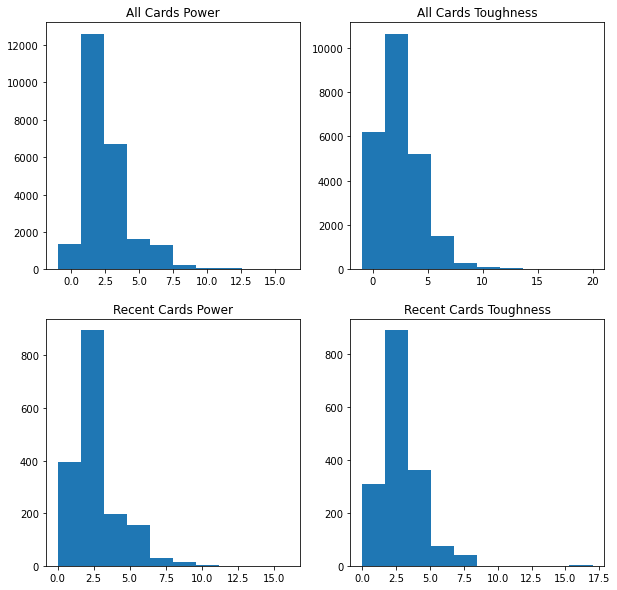

All Cards Power
Jarque-Bera test statistics is 17856.396461443754 and p value is 0.0
Normality test statistics is 6166.444936894936 and p value is 0.0
All Cards Toughness
Jarque-Bera test statistics is 21649.741243372573 and p value is 0.0
Normality test statistics is 6505.3471443137805 and p value is 0.0
Recent Cards Power
Jarque-Bera test statistics is 1440.0429749897903 and p value is 0.0
Normality test statistics is 431.6929004802047 and p value is 1.815840600620521e-94
Recent Cards Toughness
Jarque-Bera test statistics is 5448.575333806099 and p value is 0.0
Normality test statistics is 671.685149205802 and p value is 1.3977292761408054e-146


In [299]:
#we'll check for normality of the data of both cards and recent_cards
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.hist(cards['Power'])
plt.title('All Cards Power')

plt.subplot(2, 2, 2)
plt.hist(cards['Toughness'])
plt.title('All Cards Toughness')

plt.subplot(2, 2, 3)
plt.hist(recent_cards['Power'])
plt.title('Recent Cards Power')

plt.subplot(2, 2, 4)
plt.hist(recent_cards['Toughness'])
plt.title('Recent Cards Toughness')
plt.show()

jb_stats = jarque_bera(cards['Power'])
norm_stats = normaltest(cards['Power'])

print("All Cards Power")
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(cards['Toughness'])
norm_stats = normaltest(cards['Toughness'])

print("All Cards Toughness")
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

print("Recent Cards Power")
jb_stats = jarque_bera(recent_cards['Power'])
norm_stats = normaltest(recent_cards['Power'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

print("Recent Cards Toughness")
jb_stats = jarque_bera(recent_cards['Toughness'])
norm_stats = normaltest(recent_cards['Toughness'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Both the histograms and the Jarque-Bera and normality tests confirm that the data is not normally distributed. We'll attempt some data transformation.<br>
As a note, some of the values for power and toughness are either negative integers or zero, so we'll drop all negative values (3 rows) and convert all zero values to 0.0001 to allow for the transformation.

In [300]:
#restore the data
cards = cards_copy.copy()
recent_cards = recent_cards_copy.copy()

#drop the highly correlated values
cards = cards.drop(['Generic Cost', 'White CI', 'Blue CI', 'Black CI',
                   'Red CI', 'Green CI'], axis=1)
recent_cards = recent_cards.drop(['isFullArt', 'isTextless', 'isTimeshifted',
                                 'Black Border', '1993 Frame', '1997 Frame',
                                 '2003 Frame', '2015 Frame', 'Flip Card',
                                 'Level Card', 'Meld Card', 'Transform Card'], 1)
recent_cards = recent_cards.drop(['White CI', 'Blue CI', 'Black CI',
                                 'Red CI', 'Green CI', 'Generic Cost'], 1)

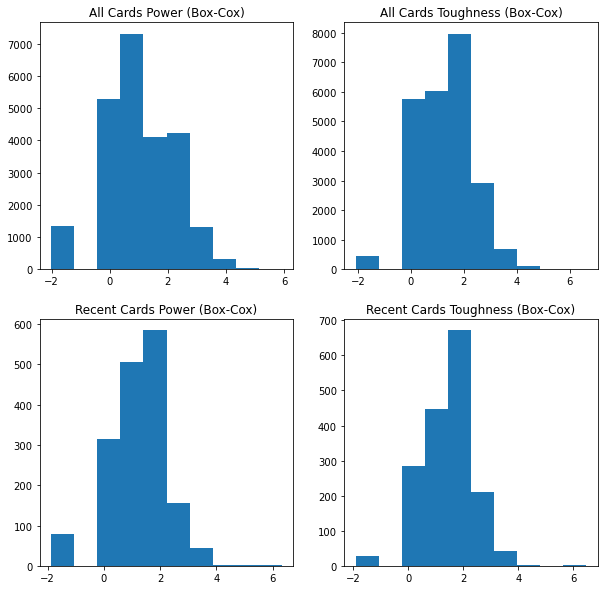

None
All Cards Power
Jarque-Bera test statistics is 1369.6054933116811 and p value is 0.0
Normality test statistics is 829.8502077634437 and p value is 6.314180330823083e-181
All Cards Toughness
Jarque-Bera test statistics is 675.6403082158643 and p value is 0.0
Normality test statistics is 351.2709237235649 and p value is 5.278227279151393e-77
Recent Cards Power
Jarque-Bera test statistics is 124.08442460312094 and p value is 0.0
Normality test statistics is 67.72893518780313 and p value is 1.9626759074150363e-15
Recent Cards Toughness
Jarque-Bera test statistics is 179.65572909706935 and p value is 0.0
Normality test statistics is 63.143910058471725 and p value is 1.9430060277500233e-14


In [301]:
#boxcox won't work with negative values so we'll drop any less than 0 and
#change the 0s to 0.0001
cards = cards[cards['Power'] >= 0]
cards = cards[cards['Toughness'] >= 0]
recent_cards = recent_cards[recent_cards['Power'] >= 0]
recent_cards = recent_cards[recent_cards['Toughness'] >= 0]

cards['Power'] = np.where(cards['Power'] == 0, 0.0001, cards['Power'])
cards['Toughness'] = np.where(cards['Toughness'] == 0, 0.0001, cards['Toughness'])
recent_cards['Power'] = np.where(recent_cards['Power'] == 0, 0.0001, recent_cards['Power'])
recent_cards['Toughness'] = np.where(recent_cards['Toughness'] == 0, 0.0001, recent_cards['Toughness'])

cards_Power_boxcox,_ = boxcox(cards['Power'])
cards_Toughness_boxcox,_ = boxcox(cards['Toughness'])
recent_cards_Power_boxcox,_ = boxcox(recent_cards['Power'])
recent_cards_Toughness_boxcox,_ = boxcox(recent_cards['Toughness'])

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.hist(cards_Power_boxcox)
plt.title('All Cards Power (Box-Cox)')

plt.subplot(2, 2, 2)
plt.hist(cards_Toughness_boxcox)
plt.title('All Cards Toughness (Box-Cox)')

plt.subplot(2, 2, 3)
plt.hist(recent_cards_Power_boxcox)
plt.title('Recent Cards Power (Box-Cox)')

plt.subplot(2, 2, 4)
plt.hist(recent_cards_Toughness_boxcox)
plt.title('Recent Cards Toughness (Box-Cox)')
print(plt.show())

jb_stats = jarque_bera(cards_Power_boxcox)
norm_stats = normaltest(cards_Power_boxcox)

print("All Cards Power")
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(cards_Toughness_boxcox)
norm_stats = normaltest(cards_Toughness_boxcox)

print("All Cards Toughness")
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

print("Recent Cards Power")
jb_stats = jarque_bera(recent_cards_Power_boxcox)
norm_stats = normaltest(recent_cards_Power_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

print("Recent Cards Toughness")
jb_stats = jarque_bera(recent_cards_Toughness_boxcox)
norm_stats = normaltest(recent_cards_Toughness_boxcox)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

The data for the recent_cards seems better but the p-values suggest that the data isn't fully normalized. We'll still run the tuning algorithms in order to see if the features we want to keep are better.

In [302]:
cards['Power'],_ = boxcox(cards['Power'])
cards['Toughness'],_ = boxcox(cards['Toughness'])
tuning(cards)

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     815.8
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        03:32:25   Log-Likelihood:                -26407.
No. Observations:               23936   AIC:                         5.291e+04
Df Residuals:                   23888   BIC:                         5.330e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [303]:
recent_cards['Power'],_ = boxcox(recent_cards['Power'])
recent_cards['Toughness'],_ = boxcox(recent_cards['Toughness'])
tuning(recent_cards)

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     63.73
Date:                Sun, 21 Feb 2021   Prob (F-statistic):          7.46e-282
Time:                        03:32:43   Log-Likelihood:                -1839.1
No. Observations:                1687   AIC:                             3752.
Df Residuals:                    1650   BIC:                             3953.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

These don't look much better as far as accuracy is concerned and the kurtosis isn't much better. We'll try winsorizing the data to see if capping the outliers has any better effect.

In [305]:
#recall the data, dropping the highly correlated values
cards = cards_copy.copy()
recent_cards = recent_cards_copy.copy()
cards = cards.drop(['Generic Cost', 'White CI', 'Blue CI', 'Black CI',
                   'Red CI', 'Green CI'], axis=1)
recent_cards = recent_cards.drop(['isFullArt', 'isTextless', 'isTimeshifted',
                                 'Black Border', '1993 Frame', '1997 Frame',
                                 '2003 Frame', '2015 Frame', 'Flip Card',
                                 'Level Card', 'Meld Card', 'Transform Card'], 1)
recent_cards = recent_cards.drop(['White CI', 'Blue CI', 'Black CI',
                                 'Red CI', 'Green CI', 'Generic Cost'], 1)

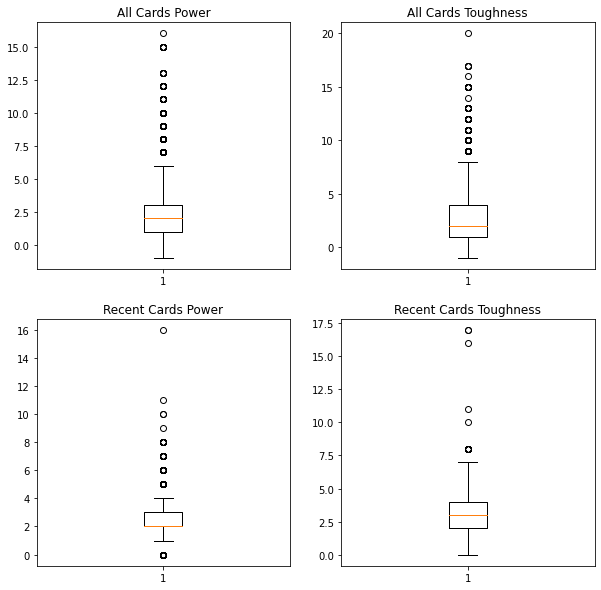

In [306]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.boxplot(cards['Power'])
plt.title('All Cards Power')

plt.subplot(2, 2, 2)
plt.boxplot(cards['Toughness'])
plt.title('All Cards Toughness')

plt.subplot(2, 2, 3)
plt.boxplot(recent_cards['Power'])
plt.title('Recent Cards Power')

plt.subplot(2, 2, 4)
plt.boxplot(recent_cards['Toughness'])
plt.title('Recent Cards Toughness')
plt.show()

In [307]:
#use a z-score with a threshold of four to find any outliers
z_scores = zscore(cards['Power'])
print('Cards Power Outliers')
print(len(np.where(z_scores > 4)[0]))
print('')
print('Cards Toughness Outliers')
z_scores = zscore(cards['Toughness'])
print(len(np.where(z_scores > 4)[0]))
print('')
print('Recent Cards Power Outliers')
z_scores = zscore(recent_cards['Power'])
print(len(np.where(z_scores > 4)[0]))
print('')
print('Recent Cards Toughness Outliers')
z_scores = zscore(recent_cards['Toughness'])
print(len(np.where(z_scores > 4)[0]))

Cards Power Outliers
132

Cards Toughness Outliers
74

Recent Cards Power Outliers
4

Recent Cards Toughness Outliers
5


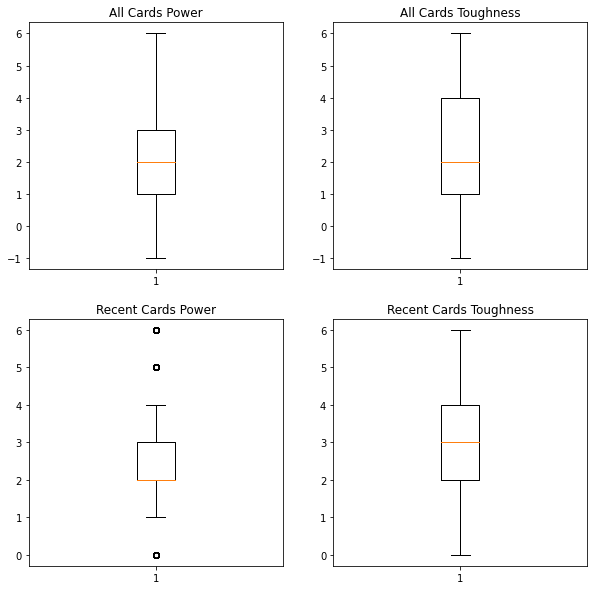

In [308]:
win_cards_power = winsorize(cards['Power'], (0, 0.05))
win_cards_toughness = winsorize(cards['Toughness'], (0, 0.05))
win_recent_cards_power = winsorize(recent_cards['Power'], (0, 0.05))
win_recent_cards_toughness = winsorize(recent_cards['Toughness'], (0, 0.05))

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.boxplot(win_cards_power)
plt.title('All Cards Power')

plt.subplot(2, 2, 2)
plt.boxplot(win_cards_toughness)
plt.title('All Cards Toughness')

plt.subplot(2, 2, 3)
plt.boxplot(win_recent_cards_power)
plt.title('Recent Cards Power')

plt.subplot(2, 2, 4)
plt.boxplot(win_recent_cards_toughness)
plt.title('Recent Cards Toughness')
plt.show()

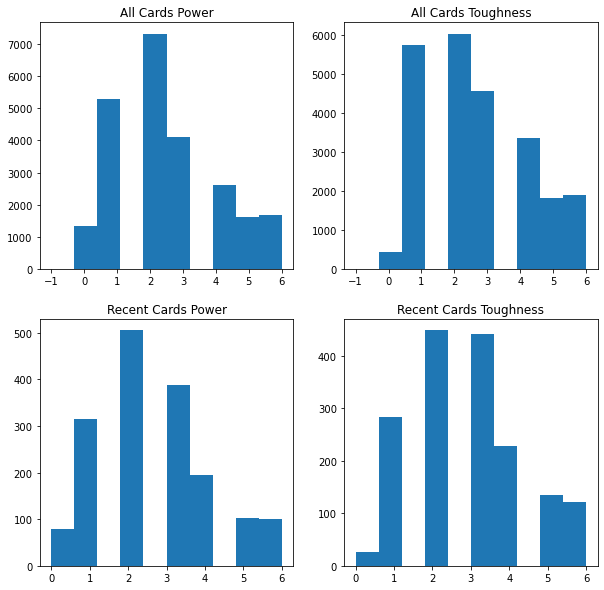

All Cards Power
Jarque-Bera test statistics is 1711.5588374136532 and p value is 0.0
Normality test statistics is 1509.733178883295 and p value is 0.0
All Cards Toughness
Jarque-Bera test statistics is 1589.9850855872307 and p value is 0.0
Normality test statistics is 1917.627265006206 and p value is 0.0
Recent Cards Power
Jarque-Bera test statistics is 90.99086761229238 and p value is 0.0
Normality test statistics is 80.50880548457809 and p value is 3.294086632839615e-18
Recent Cards Toughness
Jarque-Bera test statistics is 81.26955289309423 and p value is 0.0
Normality test statistics is 82.07683690218593 and p value is 1.5039774360666642e-18


In [309]:
cards['Power'] = win_cards_power
cards['Toughness'] = win_cards_toughness
recent_cards['Power'] = win_recent_cards_power
recent_cards['Toughness'] = win_recent_cards_toughness

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.hist(cards['Power'])
plt.title('All Cards Power')

plt.subplot(2, 2, 2)
plt.hist(cards['Toughness'])
plt.title('All Cards Toughness')

plt.subplot(2, 2, 3)
plt.hist(recent_cards['Power'])
plt.title('Recent Cards Power')

plt.subplot(2, 2, 4)
plt.hist(recent_cards['Toughness'])
plt.title('Recent Cards Toughness')
plt.show()

jb_stats = jarque_bera(cards['Power'])
norm_stats = normaltest(cards['Power'])

print("All Cards Power")
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(cards['Toughness'])
norm_stats = normaltest(cards['Toughness'])

print("All Cards Toughness")
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

print("Recent Cards Power")
jb_stats = jarque_bera(recent_cards['Power'])
norm_stats = normaltest(recent_cards['Power'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

print("Recent Cards Toughness")
jb_stats = jarque_bera(recent_cards['Toughness'])
norm_stats = normaltest(recent_cards['Toughness'])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

These don't look especially normally distributed. We'll run the tuning algorith really quickly but unless the accuracy is great we won't attempt to optimize.

In [310]:
tuning(cards)

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     1033.
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        03:41:39   Log-Likelihood:                -31649.
No. Observations:               23938   AIC:                         6.339e+04
Df Residuals:                   23890   BIC:                         6.378e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [311]:
tuning(recent_cards)

                            OLS Regression Results                            
Dep. Variable:                  Power   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     83.73
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        03:41:58   Log-Likelihood:                -2186.2
No. Observations:                1687   AIC:                             4446.
Df Residuals:                    1650   BIC:                             4647.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

Winsorizing the data didn't particularly help so we'll move on to models that aren't based on linear regression.

In [312]:
#recall the data, dropping the highly correlated values
cards = cards_copy.copy()
recent_cards = recent_cards_copy.copy()
cards = cards.drop(['Generic Cost', 'White CI', 'Blue CI', 'Black CI',
                   'Red CI', 'Green CI'], axis=1)
recent_cards = recent_cards.drop(['isFullArt', 'isTextless', 'isTimeshifted',
                                 'Black Border', '1993 Frame', '1997 Frame',
                                 '2003 Frame', '2015 Frame', 'Flip Card',
                                 'Level Card', 'Meld Card', 'Transform Card'], 1)
recent_cards = recent_cards.drop(['White CI', 'Blue CI', 'Black CI',
                                 'Red CI', 'Green CI', 'Generic Cost'], 1)

In [316]:
lr_test(cards, 2500)

Logistic Regression
R-squared of the model in the training set is: 0.49389033942558747
R-squared of the model in the test set is: 0.47514619883040937

Mean absolute error of the prediction is: 0.7491645781119465
Mean squared error of the prediction is: 1.440894e+00
Root mean squared error of the prediction is: 1.2003724011406698
Mean absolute percentage error of the prediction is: inf


In [317]:
rfc(cards)

Random Forest Classifier
[0.68964077 0.64536341 0.62823726 0.62406015 0.61236424 0.62489557
 0.61654135 0.67418546 0.58754701 0.50229837]


In [318]:
KNNr(cards, 5)

K-Nearest Neighbors Regression
[0.70743043 0.70479656 0.65177494 0.63078784 0.68229867 0.67292504
 0.66198053 0.74533583 0.6483409  0.52194112]


In [319]:
KNNc(cards, 5)

K-Nearest Neighbors Classifier
[0.61236424 0.56223893 0.55472013 0.53383459 0.5380117  0.5342523
 0.54344194 0.58939014 0.51817802 0.44922691]


In [320]:
d_tree(cards, 4)

0.581665223519428
[0.56484145 0.5848669  0.54864413 0.55184687 0.58991786 0.58217519
 0.54283751 0.60837381 0.5840717  0.53757184]


In [321]:
d_tree_boosted(cards, 4)

-6.513506259816774
-0.002891892267302465
-0.002971106492347886
-0.0017770830907533064
-0.0010209382315213844
0.8637564688035817


In [322]:
xgboost(cards)

[03:44:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Classifier
R-squared of the model in the training set is: 0.6908093994778068
R-squared of the model in the test set is: 0.5962823725981621

Mean absolute error of the prediction is: 0.5710108604845447
Mean squared error of the prediction is: 1.099833e+00
Root mean squared error of the prediction is: 1.0487291907935001
Mean absolute percentage error of the prediction is: inf


In [323]:
lr_test(recent_cards, 2500)

Logistic Regression
R-squared of the model in the training set is: 0.5300222386953298
R-squared of the model in the test set is: 0.4260355029585799

Mean absolute error of the prediction is: 0.742603550295858
Mean squared error of the prediction is: 1.387574e+00
Root mean squared error of the prediction is: 1.1779532947010427
Mean absolute percentage error of the prediction is: inf


In [324]:
rfc(recent_cards)

Random Forest Classifier
[0.44378698 0.42011834 0.43786982 0.47928994 0.4852071  0.43786982
 0.44970414 0.43452381 0.41071429 0.39880952]


In [325]:
KNNr(recent_cards, 5)

K-Nearest Neighbors Regression
[0.5259862  0.63006869 0.49342228 0.62683963 0.4324798  0.57111759
 0.41939491 0.63416016 0.52095771 0.56670543]


In [326]:
KNNc(recent_cards, 5)

K-Nearest Neighbors Classifier
[0.44378698 0.40236686 0.44970414 0.43786982 0.47337278 0.4260355
 0.42011834 0.46428571 0.39880952 0.39285714]


In [327]:
d_tree(recent_cards, 5)

0.6468175982739854
[0.50568107 0.5546943  0.45932869 0.57646958 0.41721451 0.61074897
 0.43107332 0.67810712 0.43333975 0.45938846]


In [328]:
d_tree_boosted(recent_cards, 5)

-9.221869284248209
-0.023969486819007235
-0.010181275104018228
-0.007009699790849089
-0.004718887348246437
0.9444865453056506


Based on these results, we'll use the boosted DecisionTreeRegressor.

In [334]:
def d_tree_boosted(depth, data, target):
    print('Data used from {} dataset.'.format(data.name))
    predictions = pd.DataFrame()
    y = data[target]
    X = data.drop([target], axis=1)
    for n in range(0, 101):
        decision_tree = DecisionTreeRegressor(max_depth=depth)
        decision_tree.fit(X, y)
        predict = decision_tree.predict(X)
        predictions['predictions {}'.format(n)] = predict
        y = y - predict
    predicted = predictions.sum(axis=1)
    print("Overall R^2 for {} after 100 iterations:".format(target))
    print(np.corrcoef(data[target], predicted)[0, 1])
    importances = decision_tree.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(X.shape[1]):
        print("%2d) %-*s %f" % (f + 1, 30, 
                                X.columns.values[indices[f]], 
                                importances[indices[f]]))
    
    plt.figure()
    plt.title('Feature Importances')
    plt.bar(range(X.shape[1]), importances[indices], align='center', alpha=0.5)

    plt.xticks(range(X.shape[1]), X.columns.values[indices], rotation=90)
    plt.tight_layout()
    plt.show()

Data used from Cards dataset.
Overall R^2 for Power after 100 iterations:
0.922671933600073
 1) Reach                          0.237582
 2) isTimeshifted                  0.213114
 3) Converted Mana Cost            0.132425
 4) Toughness                      0.131530
 5) Green                          0.066930
 6) Uncommon                       0.059412
 7) Protection                     0.054829
 8) Black                          0.042604
 9) Specific Mana Cost             0.039533
10) EG Keywords                    0.022040
11) Double strike                  0.000000
12) Lifelink                       0.000000
13) Haste                          0.000000
14) Flying                         0.000000
15) Flash                          0.000000
16) First strike                   0.000000
17) Set Keywords                   0.000000
18) Defender                       0.000000
19) Deathtouch                     0.000000
20) Vigilance                      0.000000
21) Red                     

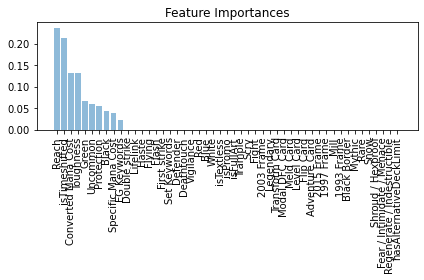

In [335]:
d_tree_boosted(4, cards, 'Power')

It looks like most of the keywords aren't important. We'll drop all of them (keeping EG Keywords) and see if the importances shift any.

In [338]:
cards = cards.drop(['Deathtouch', 'Defender', 'Double strike', 'First strike', 'Fight',
                    'Flash', 'Flying', 'Haste', 'Lifelink', 'Protection', 'Scry', 'Reach', 
                    'Trample', 'Vigilance', 'Fight', 'Mill', 'Regenerate / Indestructible',
                    'Fear / Intimidate / Menace', 'Shroud / Hexproof'], axis = 1)
d_tree_boosted(4, cards, 'Power')

Data used from Cards dataset.
Overall R^2 for Power after 100 iterations:
0.9086295014303585
 1) Converted Mana Cost            0.314339
 2) Black Border                   0.237887
 3) 2003 Frame                     0.143255
 4) Toughness                      0.106214
 5) Red                            0.047920
 6) 1993 Frame                     0.033011
 7) Blue                           0.030276
 8) Specific Mana Cost             0.024756
 9) Legendary                      0.021479
10) Snow                           0.020817
11) Flip Card                      0.020046
12) White                          0.000000
13) Uncommon                       0.000000
14) isTextless                     0.000000
15) Black                          0.000000
16) isPromo                        0.000000
17) isFullArt                      0.000000
18) Green                          0.000000
19) isTimeshifted                  0.000000
20) Set Keywords                   0.000000
21) Rare                   

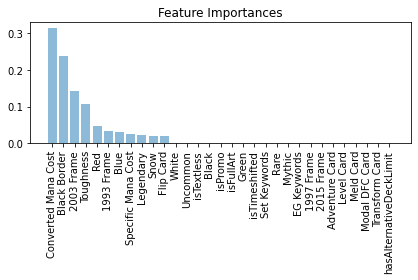

In [341]:
d_tree_boosted(4, cards, 'Power')

hasAlternativeDeckLimit, layout, isTimeshifted, isFullArt, isPromo, and isTextless seem to be insignificant. We'll drop those and rerun it.

In [343]:
cards = cards.drop(['hasAlternativeDeckLimit', 'Adventure Card', 'Flip Card',
                    'Level Card', 'Meld Card', 'Modal DFC Card', 'Transform Card',
                   'isTimeshifted', 'isFullArt', 'isPromo', 'isTextless'], 1)
cards.name = 'Cards'

Data used from Cards dataset.
Overall R^2 for Power after 100 iterations:
0.9094875279484586
 1) 1993 Frame                     0.379381
 2) Converted Mana Cost            0.158866
 3) Rare                           0.152336
 4) Blue                           0.100811
 5) White                          0.059628
 6) EG Keywords                    0.053420
 7) 2003 Frame                     0.035006
 8) Green                          0.025305
 9) Toughness                      0.020896
10) Specific Mana Cost             0.014349
11) Snow                           0.000000
12) Black                          0.000000
13) Red                            0.000000
14) Set Keywords                   0.000000
15) Uncommon                       0.000000
16) Mythic                         0.000000
17) 1997 Frame                     0.000000
18) 2015 Frame                     0.000000
19) Legendary                      0.000000
20) Black Border                   0.000000


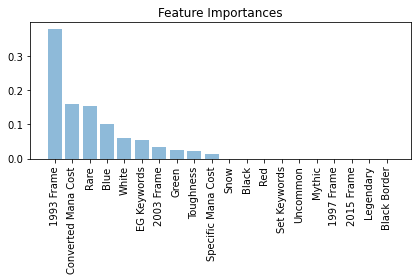

In [345]:
d_tree_boosted(4, cards, 'Power')

Data used from Cards dataset.
Overall R^2 for Power after 100 iterations:
0.9087871913529734
 1) Set Keywords                   0.305217
 2) Red                            0.233460
 3) Green                          0.139972
 4) Converted Mana Cost            0.135948
 5) Uncommon                       0.054360
 6) Specific Mana Cost             0.046629
 7) Toughness                      0.042446
 8) 1997 Frame                     0.041967
 9) Blue                           0.000000
10) Black                          0.000000
11) 1993 Frame                     0.000000
12) Rare                           0.000000
13) Mythic                         0.000000
14) EG Keywords                    0.000000
15) 2003 Frame                     0.000000
16) 2015 Frame                     0.000000
17) White                          0.000000


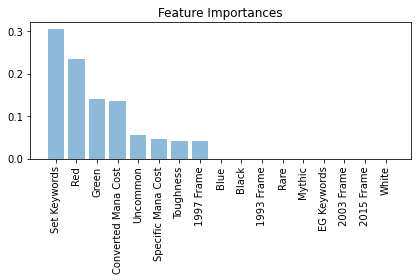

In [346]:
cards = cards.drop(['Black Border', 'Legendary', 'Snow'], 1)
cards.name = 'Cards'
d_tree_boosted(4, cards, 'Power')

Data used from Cards dataset.
Overall R^2 for Power after 100 iterations:
0.9038290601971739
 1) Uncommon                       0.241482
 2) Black                          0.240214
 3) Converted Mana Cost            0.185040
 4) Rare                           0.149844
 5) White                          0.096806
 6) Set Keywords                   0.035058
 7) Specific Mana Cost             0.030757
 8) EG Keywords                    0.016774
 9) Toughness                      0.004026
10) Mythic                         0.000000
11) Green                          0.000000
12) Red                            0.000000
13) Blue                           0.000000


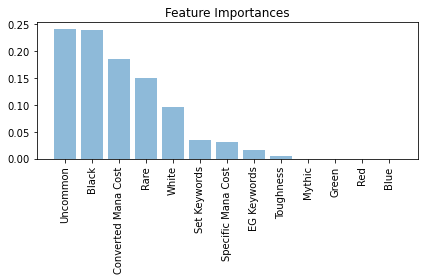

In [347]:
cards = cards.drop(['1993 Frame', '1997 Frame', '2003 Frame', '2015 Frame'], 1)
cards.name = 'Cards'
d_tree_boosted(4, cards, 'Power')

It seems removing the features decresed the accuracy of the model. However, over 90% is still very good. Let's do the same for recent_cards.

Data used from Recent Cards dataset.
Overall R^2 for Power after 100 iterations:
0.9652369431608685
 1) Rare                           0.307133
 2) Flying                         0.137952
 3) Toughness                      0.132466
 4) Green                          0.103106
 5) Uncommon                       0.092669
 6) Converted Mana Cost            0.088575
 7) Regenerate / Indestructible    0.049193
 8) Adventure Card                 0.036345
 9) Flash                          0.028394
10) Blue                           0.024168
11) First strike                   0.000000
12) Double strike                  0.000000
13) Defender                       0.000000
14) Set Keywords                   0.000000
15) Deathtouch                     0.000000
16) Red                            0.000000
17) Lifelink                       0.000000
18) Black                          0.000000
19) White                          0.000000
20) isPromo                        0.000000
21) Haste           

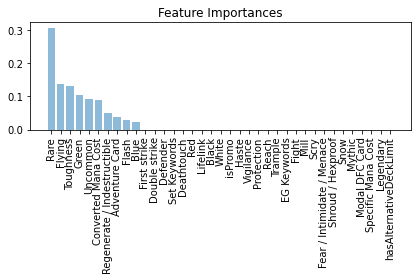

In [349]:
recent_cards.name = 'Recent Cards'
d_tree_boosted(4, recent_cards, 'Power')

Data used from Recent Cards dataset.
Overall R^2 for Power after 100 iterations:
0.9540286405728193
 1) Legendary                      0.323054
 2) Toughness                      0.282378
 3) Black                          0.137478
 4) Green                          0.069068
 5) Converted Mana Cost            0.065171
 6) Specific Mana Cost             0.058401
 7) White                          0.035737
 8) Uncommon                       0.020015
 9) Red                            0.008697
10) Flying                         0.000000
11) isPromo                        0.000000
12) Blue                           0.000000
13) Set Keywords                   0.000000
14) Snow                           0.000000
15) EG Keywords                    0.000000
16) Rare                           0.000000
17) Mythic                         0.000000
18) Adventure Card                 0.000000
19) Modal DFC Card                 0.000000
20) hasAlternativeDeckLimit        0.000000


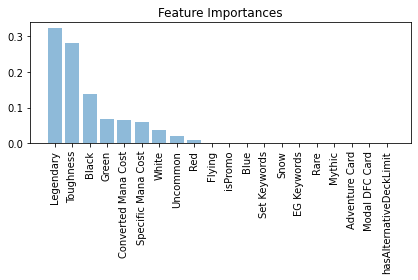

In [353]:
recent_cards = recent_cards.drop(['Deathtouch', 'Defender', 'Double strike', 'First strike',
                    'Fight', 'Flash', 'Haste', 'Lifelink', 'Protection', 'Scry', 'Reach', 
                    'Trample', 'Vigilance', 'Fight', 'Mill', 'Regenerate / Indestructible',
                    'Fear / Intimidate / Menace', 'Shroud / Hexproof'], axis = 1)
recent_cards.name = 'Recent Cards'
d_tree_boosted(4, recent_cards, 'Power')

Data used from Recent Cards dataset.
Overall R^2 for Power after 100 iterations:
0.950348982080887
 1) Toughness                      0.247313
 2) Green                          0.129023
 3) Converted Mana Cost            0.127640
 4) Set Keywords                   0.103437
 5) Legendary                      0.102753
 6) Specific Mana Cost             0.082423
 7) Blue                           0.078330
 8) Rare                           0.073157
 9) Black                          0.038891
10) White                          0.017032
11) isPromo                        0.000000
12) Uncommon                       0.000000
13) Red                            0.000000
14) Snow                           0.000000
15) EG Keywords                    0.000000
16) Mythic                         0.000000
17) hasAlternativeDeckLimit        0.000000


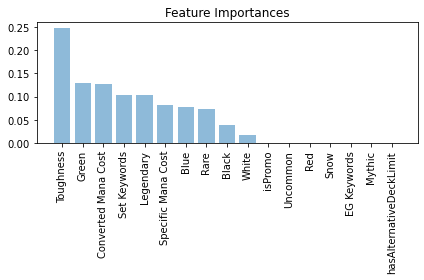

In [357]:
recent_cards = recent_cards.drop(['Flying', 'Adventure Card', 'Modal DFC Card'], axis = 1)
recent_cards.name = 'Recent Cards'
d_tree_boosted(4, recent_cards, 'Power')

Data used from Recent Cards dataset.
Overall R^2 for Power after 100 iterations:
0.9503244175593256
 1) Legendary                      0.340885
 2) Converted Mana Cost            0.282294
 3) Toughness                      0.250498
 4) Specific Mana Cost             0.047944
 5) Rare                           0.044375
 6) Mythic                         0.034005
 7) Set Keywords                   0.000000
 8) EG Keywords                    0.000000
 9) Uncommon                       0.000000
10) Snow                           0.000000
11) Green                          0.000000
12) Red                            0.000000
13) Black                          0.000000
14) Blue                           0.000000
15) White                          0.000000


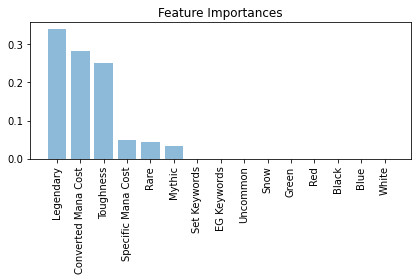

In [358]:
recent_cards = recent_cards.drop(['hasAlternativeDeckLimit', 'isPromo'], axis = 1)
recent_cards.name = 'Recent Cards'
d_tree_boosted(4, recent_cards, 'Power')

Data used from Recent Cards dataset.
Overall R^2 for Power after 100 iterations:
0.9503244175593256
 1) Legendary                      0.340885
 2) Converted Mana Cost            0.282294
 3) Toughness                      0.251577
 4) Specific Mana Cost             0.046865
 5) Rare                           0.044375
 6) Mythic                         0.034005
 7) Set Keywords                   0.000000
 8) EG Keywords                    0.000000
 9) Uncommon                       0.000000
10) Green                          0.000000
11) Red                            0.000000
12) Black                          0.000000
13) Blue                           0.000000
14) White                          0.000000


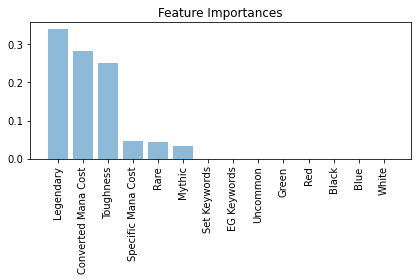

In [359]:
recent_cards = recent_cards.drop(['Snow'], axis = 1)
recent_cards.name = 'Recent Cards'
d_tree_boosted(4, recent_cards, 'Power')

Data used from Recent Cards dataset.
Overall R^2 for Power after 100 iterations:
0.9196804837094021
 1) Converted Mana Cost            0.450470
 2) Set Keywords                   0.239007
 3) Specific Mana Cost             0.134640
 4) Toughness                      0.111902
 5) EG Keywords                    0.054750
 6) Rare                           0.007710
 7) Legendary                      0.001523
 8) Mythic                         0.000000
 9) Uncommon                       0.000000


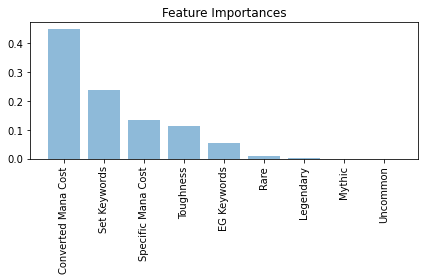

In [360]:
recent_cards = recent_cards.drop(['White', 'Blue', 'Black', 'Red', 'Green'], axis = 1)
recent_cards.name = 'Recent Cards'
d_tree_boosted(4, recent_cards, 'Power')

The color is extremely significant based on the drop in accuracy. It's also relevant because the number of cards in a specific color. We can now properly identify Power but it would be great to also identify other attributes of the cards, like Toughness, Specific Mana Cost, Keywords, etc. The distribution of colors, rarities, and Converted Mana Cost among Creatures each set don't vary much so we'll attempt to treat anything else as targets.